# Activation Patching on Full Prefix

In [1]:
#@title Import libraries
import transformer_lens
import torch, gc, itertools, functools, tqdm, copy
import pandas as pd
import numpy as np
from typing import Callable

import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
torch.set_grad_enabled(False)

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

#mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import modelHandlers, dataLoaders, patching

## Model

In [13]:
model_type = "gpt-neo-125M"
model = modelHandlers.load_model(model_type=model_type, DEVICE="cpu", lr=0.0, weight_decay=0.01)

Loaded pretrained model gpt-neo-125M into HookedTransformer
setting no_grad on ['embed', 'pos_embed', 'unembed', 'b_in', 'b_out', 'b_K', 'b_Q', 'b_V', 'b_O']


## Data

In [28]:
(mem_prompts, mem_counts),(non_mem_prompts,non_mem_counts) = dataLoaders.load_pile_splits(f"acc/{model_type}", as_torch=True)
train_dl, test_dl = dataLoaders.train_test_batching(mem_prompts, non_mem_prompts, mem_batch=5, non_mem_batch=5, test_frac=0.2, add_bos=None)
c_toks_NI, k_toks_NI = next(iter(train_dl))
c_toks_NI, k_toks_NI = c_toks_NI.squeeze(0), k_toks_NI.squeeze(0)

from /home/jupyter/paraMem/data/pile_splits/acc/gpt-neo-125M loading ['mem.pt', 'non_mem.pt']...


## Activation Patching

In [46]:
def patch_activs_fn(run_activs, hook: HookPoint, insert_activs:torch.tensor, tok_idcs:torch.tensor, head_idx:int=None):
    #print(f'patching {hook.name}')
    insert_activs = insert_activs[hook.name]
    if len(insert_activs.shape) == 4: ## pick attention head
        head_idcs = (torch.ones(tok_idcs.shape[0])*head_idx).long()
        run_activs[tok_idcs[:,0],tok_idcs[:,1],head_idcs] = insert_activs[tok_idcs[:,0],tok_idcs[:,1],head_idcs]
    else:
        run_activs[tok_idcs[:,0],tok_idcs[:,1]] = insert_activs[tok_idcs[:,0],tok_idcs[:,1]]
    return run_activs

def perform_intervention(run_toks:str, insert_activs:torch.FloatTensor, patch_activs_fn:Callable, tok_idcs:int, layer:int, c_type:str, head_idx:int=None):
    partial_patch_activs_fn = functools.partial(patch_activs_fn, insert_activs=insert_activs, tok_idcs=tok_idcs, head_idx=head_idx)    
    layer_c_type = transformer_lens.utils.get_act_name(c_type, layer)
    patch_layers_fn = [(layer_c_type, partial_patch_activs_fn)]
    patched_logits = model.run_with_hooks(run_toks, fwd_hooks=patch_layers_fn,return_type="logits",reset_hooks_end=True)
    return patched_logits

def intervention_loop(model, clean_toks_NI:torch.tensor, pertubed_toks_NI:torch.tensor, patch_toks:torch.tensor, metric_range:list, c_type:str):
    
    ## clean prompt__________________________
    clean_logits_NIT, clean_activs = model.run_with_cache(clean_toks_NI)    
    clean_nll_NI = modelHandlers.gather_token_scores(modelHandlers.NegLogLik(clean_logits_NIT.to("cpu")), clean_toks_NI)
    clean_cont_nll_NI = clean_nll_NI[:,metric_range[0]:metric_range[1]]#.mean(-1)
    
    ## corrupted prompt______________________
    corrupted_logits_NIT, corrupted_activs = model.run_with_cache(pertubed_toks_NI)    
    corrupted_nll_NI = modelHandlers.gather_token_scores(modelHandlers.NegLogLik(corrupted_logits_NIT.to("cpu")), clean_toks_NI)
    corrupted_cont_nll_NI = corrupted_nll_NI[:,metric_range[0]:metric_range[1]]#.mean(-1)
    
    print(f"mean: clean_nll_NI: {clean_nll_NI.mean()}, corrupted_nll_NI {corrupted_nll_NI.mean()}")
    print(f"clean_cont_nll_NI: {clean_cont_nll_NI.mean()}, corrupted_cont_nll_NI {corrupted_cont_nll_NI.mean()}")

    metric_res = list()#torch.zeros(model.cfg.n_layers, len(c_types))
    for i, layer in enumerate(tqdm.tqdm(range(0,model.cfg.n_layers))):
        layer_res = list()
        for j, patch_tok in enumerate(patch_toks):

            ## (1) perform intervention
            src_NI = torch.stack((torch.arange(0,clean_toks_NI.shape[0]), torch.ones(clean_toks_NI.shape[0])*patch_tok), dim=0).T.long()
            patched_logits_NIT = perform_intervention(clean_toks_NI, corrupted_activs, patch_activs_fn, src_NI, layer, c_type)

            ## (2) define intervention metrics
            patched_nll_NI = modelHandlers.gather_token_scores(modelHandlers.NegLogLik(patched_logits_NIT.to("cpu")), clean_toks_NI) ## get pred NLL
            patched_cont_nll_NI = patched_nll_NI[:,metric_range[0]:metric_range[1]]#.mean(-1)

            #nll_change = (corrupted_cont_nll_NI.mean() - patched_cont_nll_NI.mean())
            nll_change = torch.sub(patched_cont_nll_NI, clean_cont_nll_NI) #(patched_cont_nll_NI - clean_cont_nll_NI)  #/ (corrupted_cont_nll_NI-clean_cont_nll_NI)
            nll_change = nll_change.mean()
            #metric_res[i,j] = nll_change

            layer_res.append(nll_change)
        metric_res.append(layer_res)
    return torch.tensor(metric_res), patch_toks.tolist()

c_type= "attn_out"
patch_toks = torch.arange(40,50)
metric_range = [50,99]
metric_res, tok_pos_names = intervention_loop(model, c_toks_NI, k_toks_NI, patch_toks, metric_range, c_type)

mean: clean_nll_NI: 0.9418269395828247, corrupted_nll_NI 14.300050735473633
clean_cont_nll_NI: 0.1888941377401352, corrupted_cont_nll_NI 15.682465553283691


100%|██████████| 12/12 [00:57<00:00,  4.78s/it]


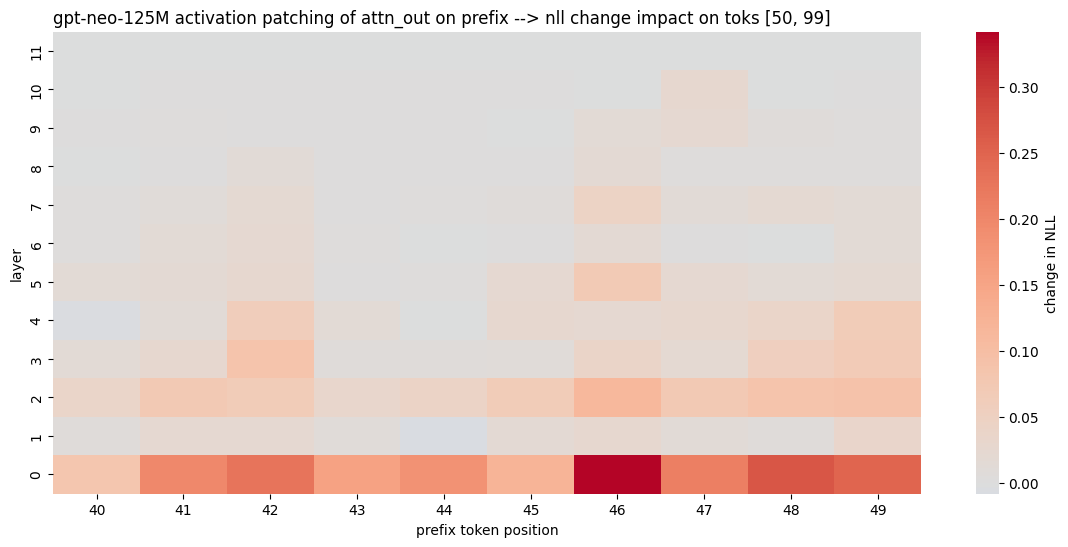

In [48]:
def plot_heatmap(vals:list, x_labels:list=None, y_labels:list=None, c_type:str=""):
    fig, ax = plt.subplots(1, 1, figsize=(14, 6), gridspec_kw={'hspace': 0.4})
    fontsize = 12
    ax = sns.heatmap(vals,
                  cmap=mpl.colormaps["coolwarm"], center=0, #coolwarm
                  xticklabels=x_labels,
                  yticklabels=y_labels, square=False, cbar_kws={'label': 'change in NLL'})
    ax.invert_yaxis()
    ax.set_ylabel("layer")
    ax.set_xlabel("prefix token position")
    ax.set_title(f"{model_type} activation patching of {c_type} on prefix --> nll change impact on toks {metric_range}", fontsize=fontsize, loc="left")

plot_heatmap(metric_res, x_labels=tok_pos_names, y_labels=np.arange(0,model.cfg.n_layers), c_type=c_type)